# Keras MobileNet Benchmark
(Note: Forked from Beluga : [https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892])

In a previous benchmark we used a simple three layer ConvNet. This time we use a deeper MobileNet architecture on greyscale strokes. 

This kernel has three main components:

* MobileNet
* Fast and memory efficient Image Generator with temporal 
* Full training & submission with Kaggle Kernel

I did some paramer search but it should not be hard to improve the current score.

## Setup
Import the necessary libraries and a few helper functions.

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import json
import datetime as dt

import cv2
import math
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam

from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

start = dt.datetime.now()

Using TensorFlow backend.


In [2]:
DP_DIR = 'shuffle_csvs/'
INPUT_DIR = '../input/'

NCSVS = 200
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

In [3]:
def f2cat(filename: str) -> str: return filename.split('.')[0]
def list_all_categories(): return sorted([f2cat(f) for f in os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))], key=str.lower)
def apk(actual, predicted, k=3):
    if len(predicted) > k: predicted = predicted[:k]
    score, num_hits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if len(actual)==0: return 0.0
    return score / min(len(actual), k)
def mapk(actual, predicted, k=3): return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])
def preds2catids(predictions): return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])
def top_3_accuracy(y_true, y_pred): return top_k_categorical_accuracy(y_true, y_pred, k=3)
log_keys = ('loss', 'val_loss', 'categorical_accuracy', 'top_3_accuracy', 'val_categorical_accuracy', 'val_top_3_accuracy')
def print_history(hists): print("\n".join(["\t".join(["%.3f"%hist.history[key][-1] for key in log_keys]) for hist in hists]))

## MobileNet

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)

In [4]:
batchsize = 256
STEPS = 2000
val_steps = 500
EPOCHS = 10

In [5]:
image_size = 128
time_color = True
stroke_size = 3

# Pre-compute downsizer and stroke color over time ranges for faster computation
sampler = [round(i*(image_size-10)/256)+5 for i in range(512)]
stroke_color = defaultdict(lambda: 125 if time_color else 255,
        {t:255-min(t,10)*13 for t in range(10)} if time_color else {})

In [61]:
def draw_cv2(img, raw_strokes):    
    for t in range(len(raw_strokes)-1, -1, -1):
        stroke = raw_strokes[t]
        for i in range(len(stroke[0]) - 1):
            cv2.line(img,
                (sampler[stroke[0][i]],   sampler[stroke[1][i]]),
                (sampler[stroke[0][i+1]], sampler[stroke[1][i+1]]),
                stroke_color[i], stroke_size)

In [7]:
def image_generator_xd(batchsize, ks):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df.drawing = df.drawing.apply(json.loads)
                
                x = np.zeros((len(df), image_size, image_size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    draw_cv2(x[i], raw_strokes)
                x = preprocess_input(x).astype(np.float32)
                
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

In [ ]:
def draw_cv2(raw_strokes, size=size, lw=stroke_size, time_color=True):
    img = np.zeros((size, size), np.uint8)
    for t in range(len(raw_strokes)-1, -1, -1):
        stroke = raw_strokes[t]
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    return img

    
def sample(strokes, downsize_to=size-2):
    division = 256 / downsize_to
    for i in range(len(strokes)):
        for j in range(len(strokes[i])):
            for k in range(len(strokes[i][j])):
                strokes[i][j][k] = round(strokes[i][j][k]/division)+1
    return strokes

def image_generator_xd(size, batchsize, ks, lw=stroke_size, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df.drawing.apply(ast.literal_eval)
                df['scaled_drawing'] = df.drawing.apply(sample)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.scaled_drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, lw=lw, time_color=True)
                x = preprocess_input(x).astype(np.float32)
                
                df['drawing'] = df['drawing'].map(_stack_it)
                
                
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield [x, np.stack(df['drawing'], 0)], y

# def image_generator_xd(size, batchsize, ks, lw=stroke_size, time_color=True):
#     while True:
#         for k in np.random.permutation(ks):
#             filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
#             for df in pd.read_csv(filename, chunksize=batchsize):
#                 df['drawing1'] = df['drawing'].apply(ast.literal_eval)
#                 x = np.zeros((len(df), size, size, 1))
#                 for i, raw_strokes in enumerate(df.drawing1.values):
#                     x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
#                                              time_color=time_color)
# #                 x = np.repeat(x, 3, axis =3)
#                 x = preprocess_input(x).astype(np.float32)
                
#                 df['drawing'] = df['drawing'].map(_stack_it)
#                 x2 = np.stack(df['drawing'], 0)
#                 y = keras.utils.to_categorical(df.y, num_classes=NCATS)
#                 yield [x, x2], y


def df_to_image_array_xd(df, size, lw=stroke_size, time_color=True):
    df['drawing'] = df.drawing.apply(ast.literal_eval)
    df['scaled_drawing'] = df.drawing.apply(sample)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.scaled_drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, lw=lw, time_color=True)
    x = preprocess_input(x).astype(np.float32)
    
    df['drawing'] = df['drawing'].map(_stack_it)
    x2 = np.stack(df['drawing'], 0)

    return [x, x2]

# def df_to_image_array_xd(df, size, lw=stroke_size, time_color=True):
#     df['drawing1'] = df['drawing'].apply(ast.literal_eval)
#     x = np.zeros((len(df), size, size, 1))
    
#     for i, raw_strokes in enumerate(df.drawing1.values):
#         x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
# #     x = np.repeat(x, 3, axis =3)
#     x = preprocess_input(x).astype(np.float32)
#     df['drawing'] = df['drawing'].map(_stack_it)
#     x2 = np.stack(df['drawing'], 0)
#     return [x,x2]

In [8]:
train_datagen = image_generator_xd(batchsize, range(190))
valid_datagen = image_generator_xd(batchsize, range(190, 200))

In [9]:
description = "FastLoader.%d.%d.%d.%s"%(image_size, batchsize, STEPS, dt.datetime.now().strftime("%d-%H%M%S"))
hist_file   = "%s%s"%(description, dt.datetime.now().strftime("%d-%H%M%S"))
hist_csv    = "%s%s.csv"%(description, dt.datetime.now().strftime("%d-%H%M%S"))

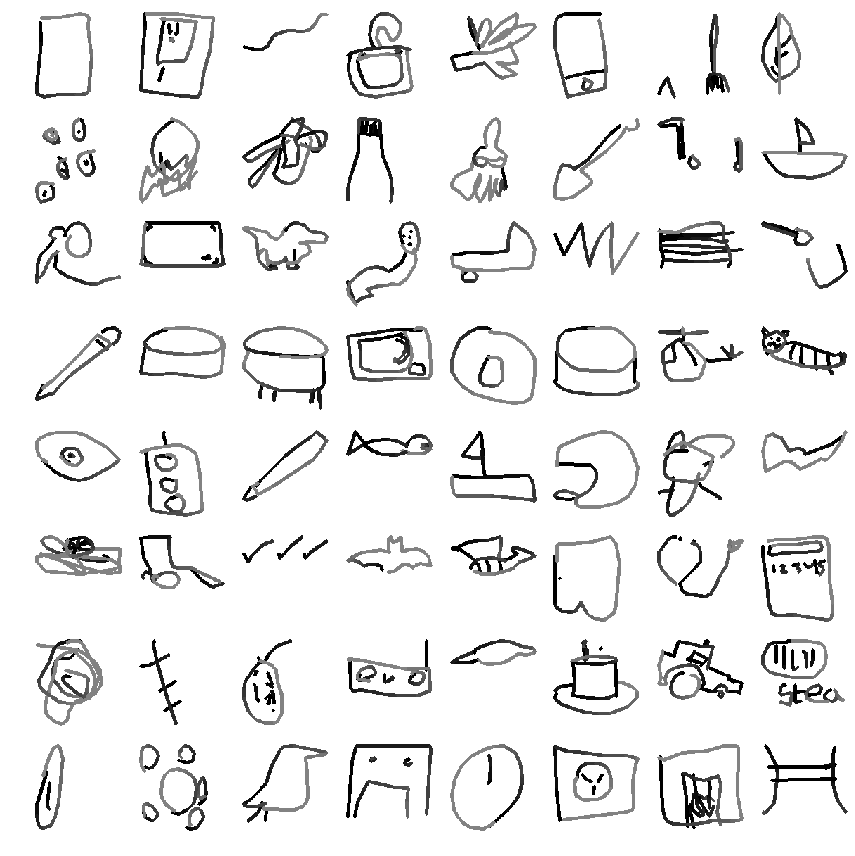

In [10]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('%s.png'%description, dpi=300)
plt.show();

In [12]:
# MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1,
#           dropout=1e-3, include_top=True, weights='imagenet',
#           input_tensor=None, pooling=None, classes=1000)

base_model = MobileNet(input_shape=(image_size, image_size, 1), alpha=1.,
                  weights=None, dropout=0.2, classes=NCATS)
base_model.load_weights("FastLoader.128.256.2000.02-0.78.h5")
base_model.compile(optimizer=Adam(lr=0.0005000000237487257), loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_3_accuracy])

In [ ]:
0.0005000000237487257

In [13]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1),
    ModelCheckpoint("%s.{epoch:02d}-{val_loss:.2f}.h5"%description,
                    monitor='val_categorical_accuracy',
                    save_weights_only=True, mode='auto', period=1),
    keras.callbacks.CSVLogger(hist_csv, separator=',', append=True)
]

In [ ]:
hists = []
hist = base_model.fit_generator(
    train_datagen,
    validation_data=valid_datagen, validation_steps=val_steps, 
    steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    callbacks = callbacks
)
hists.append(hist)
print_history(hists)

In [ ]:
hist = base_model.fit_generator(
    train_datagen,
    validation_data=valid_datagen, validation_steps=val_steps, 
    steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    callbacks = callbacks
)
hists.append(hist)
print_history(hists)

In [ ]:
hist = base_model.fit_generator(
    train_datagen,
    validation_data=valid_datagen, validation_steps=val_steps, 
    steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    callbacks = callbacks
)
hists.append(hist)
print_history(hists)

In [22]:
hists = []
hists.append(hist)
print_history(hists)
pickle.dump([hist.history for hist in hists], open(hist_file, "wb"))

0.776	0.756	0.800	0.924	0.805	0.926


In [50]:
hist = base_model.fit_generator(
    train_datagen,
    validation_data=valid_datagen, validation_steps=val_steps, 
    steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    callbacks = callbacks
)
hists.append(hist)
print_history(hists)

Epoch 1/10
2000/2000 [==============================] - 680s 340ms/step - loss: 0.7740 - categorical_crossentropy: 0.7740 - categorical_accuracy: 0.8006 - top_3_accuracy: 0.9239 - val_loss: 0.7582 - val_categorical_crossentropy: 0.7582 - val_categorical_accuracy: 0.8043 - val_top_3_accuracy: 0.9256
Epoch 2/10
2000/2000 [==============================] - 682s 341ms/step - loss: 0.7702 - categorical_crossentropy: 0.7702 - categorical_accuracy: 0.8006 - top_3_accuracy: 0.9243 - val_loss: 0.7664 - val_categorical_crossentropy: 0.7664 - val_categorical_accuracy: 0.8019 - val_top_3_accuracy: 0.9246
Epoch 3/10
2000/2000 [==============================] - 681s 340ms/step - loss: 0.7706 - categorical_crossentropy: 0.7706 - categorical_accuracy: 0.8003 - top_3_accuracy: 0.9247 - val_loss: 0.7527 - val_categorical_crossentropy: 0.7527 - val_categorical_accuracy: 0.8052 - val_top_3_accuracy: 0.9269
Epoch 4/10
2000/2000 [==============================] - 681s 341ms/step - loss: 0.7683 - categorical

TypeError: Object of type 'History' is not JSON serializable

In [ ]:
hist = base_model.fit_generator(
    train_datagen,
    validation_data=valid_datagen, validation_steps=val_steps, 
    steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    callbacks = callbacks
)
hists.append(hist)
print_history(hists)

In [59]:
hist_df_load = pd.read_csv('hist.csv')

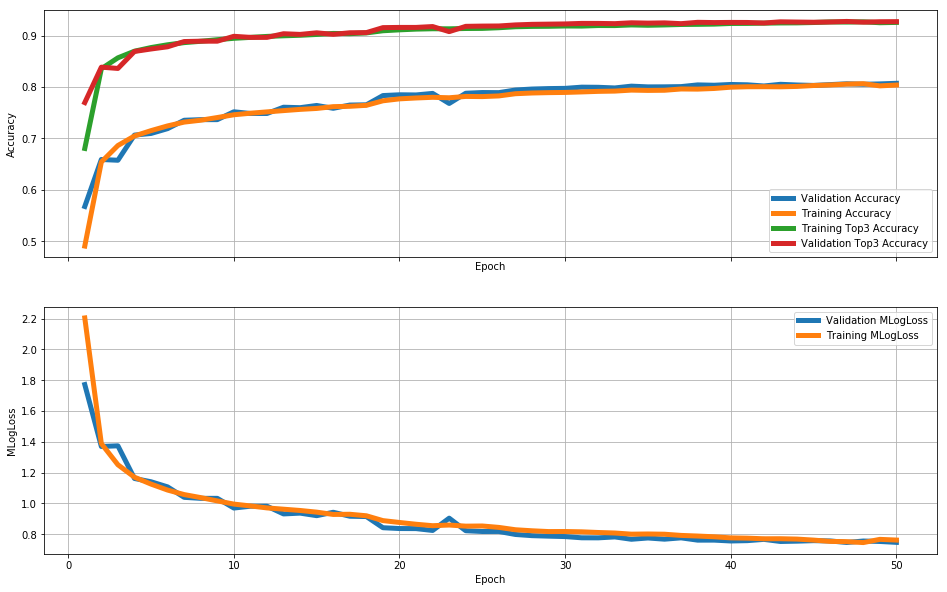

In [60]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df = pd.concat([hist_df_load, hist_df], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].plot(hist_df.top_3_accuracy, lw=5, label='Training Top3 Accuracy')
axs[0].plot(hist_df.val_top_3_accuracy, lw=5, label='Validation Top3 Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('%s.png'%description, dpi=300)
plt.show();

In [51]:
maps = []
for i in range(50):
    x_valid, y_valid = next(valid_datagen)
    valid_predictions = base_model.predict(x_valid, batch_size=256)
    map3 = mapk(np.argmax(y_valid, axis=1).reshape(-1,1), preds2catids(valid_predictions).values)
    maps.append(map3)
map3 = np.array(maps).mean()
print('Map3: {:.3f}'.format(map3))

Map3: 0.859


## Create Submission

In [53]:
def image_generator_test(filename, batchsize):
    for df in pd.read_csv(filename, chunksize=batchsize):
        df.drawing = df.drawing.apply(json.loads)

        x = np.zeros((len(df), image_size, image_size, 1))
        for i, raw_strokes in enumerate(df.drawing.values):
            draw_cv2(x[i], raw_strokes)
        x = preprocess_input(x).astype(np.float32)

        yield x

In [54]:
filepath     = os.path.join(INPUT_DIR, 'test_simplified.csv')
test_datagen = image_generator_test(filepath, batchsize)
test_predictions = base_model.predict_generator(test_datagen, steps=439)

In [55]:
test = pd.read_csv(filepath)

In [56]:
top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

,a,b,c
0,234,281,1
1,144,36,226
2,305,62,53
3,187,304,303
4,113,56,165


(112199, 3)

,a,b,c
0,radio,stereo,alarm_clock
1,hockey_puck,bottlecap,pool
2,The_Great_Wall_of_China,castle,camel
3,mountain,The_Eiffel_Tower,tent
4,fireplace,campfire,leaf


(112199, 3)

In [57]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('{}{}.csv'.format(description, int(map3 * 10**4)), index=False)
submission.head()
submission.shape

,key_id,word
0,9000003627287624,radio stereo alarm_clock
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle camel
3,9000038588854897,mountain The_Eiffel_Tower tent
4,9000052667981386,fireplace campfire leaf


(112199, 2)

In [58]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2018-12-01 23:28:09.548775.
Total time 15496s
